<a href="https://colab.research.google.com/github/fersoler/LogiCoLab/blob/main/Tableaux.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cálculo de tablas semánticas o *tableaux*


Este cuaderno forma parte del [proyecto *LogiCoLab*](https://github.com/fersoler/LogiCoLab) publicado con licencia MIT.

👇 Para cargar las funciones que se utilizan a lo largo del cuaderno, pulsar sobre ▶ en el siguiente bloque y esperar a que aparezca ✅ a la izquierda. Si no ves el signo ▶, pasa el cursor por encima de "Mostrar código".

In [1]:
#@title
from IPython.display import display, HTML, Math, Latex
import nltk
from nltk import *
import nltk.inference.tableau as tab
from nltk.sem import logic
from nltk.sem.logic import *
import networkx as nx
import graphviz
import pydot
from io import StringIO
import sys
import re
import warnings
warnings.filterwarnings("ignore")

class Capturing(list):
    def __enter__(self):
        self._stdout = sys.stdout
        sys.stdout = self._stringio = StringIO()
        return self
    def __exit__(self, *args):
        self.extend(self._stringio.getvalue().splitlines())
        del self._stringio    # free up some memory
        sys.stdout = self._stdout

read_expr = logic.Expression.fromstring

def analizaFml(cadenaFml):
  cadena = cadenaFml
  cadena = cadena.replace('¬','-')
  cadena = cadena.replace('todos','all')
  cadena = cadena.replace('todo','all')
  cadena = cadena.replace('algunos','some')
  cadena = cadena.replace('alguno','some')
  cadena = cadena.replace('algún','some')
  cadena = cadena.replace('algun','some')
  cadena = cadena.replace('existen','some')
  cadena = cadena.replace('existe','some')
  return read_expr(cadena)

def printLaTeX(nltkForm):
  cadena = str(nltkForm)
  cadena = cadena.replace('all',' \\forall ')
  cadena = cadena.replace('exists',' \\exists ')
  cadena = cadena.replace('|',' \\lor ')
  cadena = cadena.replace('&',' \\land ')
  cadena = cadena.replace('<->',' \\leftrightarrow ')
  cadena = cadena.replace('->',' \\to ')
  cadena = cadena.replace('-',' \\lnot ')
  cadena = cadena.replace('.',' ')
  return cadena

def printTXT(nltkForm):
  cadena = str(nltkForm)
  cadena = cadena.replace('all','∀')
  cadena = cadena.replace('exists','∃')
  cadena = cadena.replace('|','∨')
  cadena = cadena.replace('&','∧')
  cadena = cadena.replace('<->','↔')
  cadena = cadena.replace('->','→')
  cadena = cadena.replace('-','¬')
  cadena = cadena.replace('.',' ')
  return cadena

def tableauFml(fml):
  theFml = "-("+str(analizaFml(fml))+")"
  with Capturing() as output:
    tab.tableau_test(theFml, [], verbose=True)
  return output[1:-1]

def tableauSetFml(setFml):
  fmls = [str(analizaFml(fml)) for fml in setFml]
  theFml = "-(("+") & (".join(fmls)+"))"
  with Capturing() as output:
    tab.tableau_test(theFml, [], verbose=True)
  return output[1:-1]

def printTableau(listaTab):
  for l in listaTab:
    fl = printTXT(l.replace('-->','=>'))
    print(fl)

def NLTKtableauNX(TabList):
  G = nx.DiGraph()
  lastNodeLevel = dict()
  spaces = 0
  for i in range(len(TabList)):
    l = TabList[i]
    if '-->' in l:
      continue
    if re.search(':   \[.+\]',l):
      continue
    spacesPrev = spaces
    origSize = len(l)
    reduced = l.lstrip() # Cadena sin epacios iniciales
    spaces = origSize - len(reduced)
    reduced = reduced.rstrip(':   []').strip()
    col = "black"
    if reduced == "AGENDA EMPTY":
      reduced = "ABIERTA"
      col = "green"
    if reduced == "CLOSED":
      reduced = "⨂"
      col = "red"
    # Get index of the following node
    if spaces in lastNodeLevel:
      lastNodeLevel[spaces] += 1
    else:
      lastNodeLevel[spaces] = 1
    G.add_node(str(spaces)+"-"+str(lastNodeLevel[spaces]), label=printTXT(reduced), shape='none', fontcolor = col)
    if (spaces>0) & (i>0):
      allKeys = list(lastNodeLevel.keys())
      if spaces > spacesPrev:
        prevSpaces = spacesPrev
      else:
        prevSpaces = max([v for v in allKeys if v < spaces])
      G.add_edge(str(prevSpaces)+"-"+str(lastNodeLevel[prevSpaces]), str(spaces)+"-"+str(lastNodeLevel[spaces]), dir='none')
  return G

def toDot(table):
  G = NLTKtableauNX(table)
  dot = nx.nx_pydot.to_pydot(G)
  param = {'ranksep' : 0}
  dot.set_graph_defaults(**param)
  return str(dot)

En lógica proposicional es posible comprobar nociones semánticas como
**satisfacibilidad** o **consecuencia lógica** usando
tablas de verdad, a pesar de su elevado coste ($2^n$ filas para una fórmula con $n$ variables proposicionales). Sin embargo,
en  $\mathsf{LPO}$ **no es posible examinar todas las
posibles estructuras** de $\mathcal{L}_{\mathsf{LPO}}$ para determinar, por ejemplo, si una fórmula es satisfacible.

Los tableaux nos ofrecen un **método sistemático
de búsqueda de estructuras** que satisfacen un cierto conjunto de
fórmulas. Sirven tanto en lógica proposicional como en lógica de predicados de primer orden, y existen extensiones para diversas lógicas.

Vamos a estudiar reglas que permiten construir tableaux con los que comprobar la satisfacibilidad de fórmulas proposicionales y de predicados de primer orden sin identidad.

**Ejemplo**.  Queremos saber si el conjunto $\{p\lor q, \lnot p\land \lnot
q\}$ es satisfacible. En lugar de hacer la tabla de verdad, consideramos cómo tiene que ser una interpretación $\sigma$ que satisfaga el conjunto.
- Si $\sigma$ satisface $\{p\lor q, \lnot {p\land \lnot
q}\}$, dada la interpretación de $\land$, debe satisfacer $\{p\lor q,\lnot p, \lnot q\}$.
- Si $\sigma$ satisface $\{{p\lor q}, \lnot p, \lnot
q\}$, dada la interpretación de $\lor$, debe satisfacer uno de estos
dos conjuntos:
  - $\{p, \lnot p, \lnot q\}$, pero esto es
contradictorio, porque requeriría hacer a la vez verdaderas
$p$ y $\lnot p$.
  -  $\{{q}, \lnot p, \lnot q\}$, que también es imposible, porque requeriría hacer a la vez verdaderas $q$ y $\lnot q$.
- Por tanto, **no puede existir una interpretación**
$\sigma$ que satisfaga el conjunto original.
- Hemos hecho una **reducción al absurdo** utilizando la interpretación de las conectivas proposicionales.
- El **cálculo de tableaux** es la sistematización de este
argumento.

Los tableaux sistematizan el argumento anterior creando una estructura con forma de árbol invertido que parte de un conjunto de fórmulas $\Gamma$ (raíz) y se va ramificando hacia abajo. Cada rama del tableau representa una opción para satisfacer $\Gamma$. La construcción termina cuando encontramos una estructura que satisface $\Gamma$ (tableau abierto, $\Gamma$ satisfacible) o bien cuando se han descartado todas las opciones (tableau cerrado, $\Gamma$ no satisfacible).

Podemos ver más abajo un tableau que representa el argumento anterior, construido para la fórmula $(p  \lor q) \land \lnot p \land \lnot q$.

> 💻 Construimos los tableaux usando la [implementación](https://www.nltk.org/_modules/nltk/inference/tableau.html) disponible en la librería `NLTK`. Debemos tener en cuenta varias cosas:
- Las variables proposicionales se representan por una única letra mayúscula, como `P`o `Q`.
- El demostrador de tableaux de `NLTK` no está optimizado para generar el tableau más pequeño ni para realizar ciertas comprobaciones de no terminación.
- Cuando encuentra una rama completa abierta (más adelante veremos ejemplos) detiene la construcción pues sabemos que la fórmula es satisfacible. Eso puede dar la impresión de que faltan ramas.
- Los tableaux no están anotados, por lo que tendremos que hacer la tarea de justificar cada paso. Podemos ver tableaux anotados en [Tree Proof Generator](https://www.umsu.de/trees/#~3((P~2Q)~1~3P~1~3Q)).

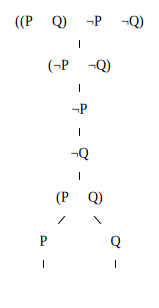

In [ ]:
#@title
table = tableauSetFml(['P | Q', '¬P & ¬Q'])
graphviz.Source(toDot(table))

## Tipos de fórmulas

Podemos clasificar las fórmulas que hemos estudiado en cinco tipos:
- Fórmulas de tipo $\alpha$, que incluyen las conjunciones $\varphi\land\psi$ pero también otras fórmulas como $\lnot (\varphi\lor\psi)$ que equivalen a una conjunción (De Morgan: $\lnot\varphi\land\lnot\psi$).
- Fórmulas de tipo $\beta$, que son las que equivalen a una disyunción.
- Fórmulas de tipo $\gamma$, que equivalen a una cuantificación universal.
- Fórmulas de tipo $\delta$, que equivalen a una cuantificación existencial.
- Literales como $p$, $\lnot q$, $Rab$, o $\lnot Pa$.

### Fórmulas $\alpha$ y $\beta$

$$
\begin{array}[t]{c|c|c}
      \alpha & \alpha_1 & \alpha_2
      \\\hline
      \varphi\wedge\psi & \varphi & \psi \\
      \neg(\varphi\vee\psi) & \neg\varphi & \neg\psi \\
      \neg(\varphi\rightarrow\psi) & \varphi & \neg\psi
    \end{array}
$$

La tabla anterior recoge las fórmulas de tipo $\alpha$, que equivalen a
la conjunción de sus componentes,
$$
\alpha \equiv \alpha_1\land \alpha_2
$$

**Ejercicio.** Comprobar la equivalencia anterior
mediante tablas de verdad, para cada fórmula de tipo $\alpha$.

$$
    \begin{array}[t]{c|c|c}
      \beta & \beta_1 & \beta_2 \\\hline
      \varphi\vee\psi & \varphi & \psi \\
      \neg(\varphi\wedge\psi) & \neg\varphi & \neg\psi \\
      \varphi\rightarrow\psi & \neg\varphi & \psi\\
      \varphi\leftrightarrow\psi & \varphi\wedge\psi &
      \neg\varphi\wedge\neg\psi \\
      \neg(\varphi\leftrightarrow\psi) & \varphi\wedge\neg\psi &
      \neg\varphi\wedge\psi
    \end{array}
$$

La tabla anterior recoge las fórmulas de tipo $\beta$, que equivalen a
la disyunción de sus componentes,
$$
\beta \equiv \beta_1\lor \beta_2
$$

**Ejercicio.** Comprobar la equivalencia anterior
mediante tablas de verdad, para cada fórmula de tipo $\beta$.

> 💡 Al hacer un tableaux, las fórmulas $\alpha$ se van a expandir (produciendo $\alpha_1$ y $\alpha_2$) en la misma rama, dado que el requisito de hacer $\alpha$ verdadera solo se puede satisfacer de una única forma. Sin embargo, las fórmulas $\beta$ se expandirán dividiendo la rama en dos y añadiendo $\beta_1$ a una rama y $\beta_2$ a otra. Se puede comprobar viendo algunos tableaux proposicionales de [Tree Proof Generator](https://www.umsu.de/trees/#(p%E2%88%A8(q%E2%88%A7r))%E2%86%92((p%E2%88%A8q)%E2%88%A7(p%E2%88%A8r))).

### Fórmulas $\gamma$ y $\delta$

$$
\begin{array}{c|c}
      \gamma & \gamma(t)\\\hline
      \phantom{\lnot}\forall x\,\varphi(x) & \phantom{\lnot}\varphi(x/t)\\
      \lnot\exists x\,\varphi(x) & \lnot\varphi(x/t)
\end{array}
$$

Las **fórmulas de tipo $\gamma$ equivalen a una
cuantificación universal** ($\lnot\exists x \varphi \equiv \forall
x\,\lnot\varphi$). La fórmula $\gamma(t)$ hace referencia al resultado de sustutir en la fórmula $\gamma$ correspondiente la variable $x$ por la constante $t$.

$$
    \begin{array}{c|c}
    \delta & \delta(a) \\\hline
      \phantom{\lnot}\exists x\, \varphi(x) & \phantom{\lnot}\varphi(x/a) \\
      \lnot\forall x\,\varphi(x) & \lnot\varphi(x/a)
    \end{array}
$$

Las **fórmulas de tipo $\delta$ equivalen a una
cuantificación existencial** ($\lnot\forall x\,\varphi \equiv \exists
x\,\lnot\varphi$).

**Proposición (Tipos de fórmulas).** Cualquier fórmula $\varphi\in\mathcal{L}_{\mathsf{LPO}}$ tiene una de las siguientes formas:
- Una fórmula atómica $P(t_1,\dots,t_n)$ o su negación
$\lnot P(t_1,\dots,t_n)$ (llamamos **literales** a estas
fórmulas)
- Una fórmula de **tipo $\alpha$** (que equivale a la
conjunción de sus componentes $\alpha_1$ y $\alpha_2$)
- Una fórmula de **tipo $\beta$** (que equivale a la
disyunción de sus componentes $\beta_1$ y $\beta_2$)
- Una **doble negación** $\lnot\lnot\psi$ ($\lnot\lnot\psi\equiv\psi$)
- Una fórmula de **tipo $\gamma$** (cuantificación
universal)
- Una fórmula de **tipo $\delta$** (cuantificación
existencial)

**Ejercicio.** ¿Cómo podemos demostrar la proposición anterior?

## Formación de tableaux

La construcción comienza como un árbol (que se irá ramificando hacia
abajo) cuya raíz es el conjunto de fórmulas de partida (cada fórmula
un nodo). Se aplican las siguientes reglas:
1. **Regla de Cierre:** Si en una rama aparecen una
fórmula $\lambda$ y su negación $\lnot\lambda$, la construcción de la
rama termina y decimos que queda cerrada. Se puede indicar con una
marca $\otimes$.
2. **Regla $\sigma$ (Doble Negación):** Si en una rama
aparece una doble negación $\lnot\lnot \psi$, se añade $\psi$ a
la rama.
3. **Regla $\alpha$:** Si en una rama hay una fórmula de
la clase $\alpha$, se añaden al final de la rama sus componentes
$\alpha_1$ y $\alpha_2$.
4. **Regla $\delta$:** Si en una rama hay una fórmula de
la clase $\delta$, se añade $\delta(a)$ a la rama para una constante
nueva $a$.
5. **Regla $\gamma$:** Si en una rama hay una fórmula de la
clase $\gamma$, se añaden las instancias $\gamma(t)$ para cada
constante $t$ que ocurra en la rama (o una constante nueva,
en su defecto). Si posteriormente aparecen nuevas constantes, se
puede volver a aplicar la regla sobre la misma fórmula.
6. **Regla $\beta$:** Si en una rama hay una fórmula de
la clase $\beta$, la rama se divide en dos, y en cada una de las ramas
resultantes se añade una de las fórmulas $\beta_1$ y $\beta_2$.

La construcción continúa hasta que todas sus ramas
se cierran (**tableau cerrado**) o no quedan
reglas por aplicar. Si queda alguna rama abierta, es un
**tableau abierto**.

💡 **Estrategia:** Es habitual que durante la construcción de un tableau podamos elegir entre varias fórmulas a las que podemos aplicar una regla. Como criterios generales, podemos considerar:
- Si detectamos que aplicando cierta regla logramos cerrar el tableau, o al menos alguna rama, es conveniente aplicar dicha regla.
- En otro caso, aplicar las reglas en el orden presentado más arriba, es decir:
  - Aplicar reglas $\delta$ antes que reglas $\gamma$. Las formulas de tipo $\delta$ introducen nuevas constantes que sirven para después instanciar las fórmulas de tipo $\gamma$.
  - Las bifurcaciones (regla $\beta$) las dehjamos para cuando no haya otra opción, con lo que tratamos de controlar el número de ramas del tableau.

🧠 Los tableaux servirán como **demostraciones** de ciertas nociones lógicas (satisfacibilidad, consecuencia lógica, etc.). Para que esas demostraciones sean comprendidas por otras personas conviene anotar los tableaux. [Este documento](https://github.com/fersoler/LogiCoLab/blob/main/doc/examplesTableaux.pdf) contiene ejemplos de tableaux anotados.





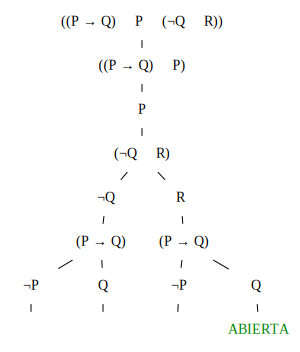

In [7]:
#@markdown # Tableau de un conjunto de fórmulas

#@markdown Introduce un conjunto de fórmulas separadas por ";" para
#@markdown construir su tableau al pulsar ▶. Ten en cuenta las observaciones realizadas más
#@markdown arriba sobre los tableaux que construye `NLTK`, como que las
#@markdown variables proposicionales se representan por una única letra
#@markdown mayúscula y que en cuanto aparece una rama completa abierta se
#@markdown dejan de desarrollar nuevas ramas.

#@markdown **Ejercicio:** Completa las ramas que no aparecen y justifica cada paso
#@markdown de los tableaux resultantes. También puedes intentar construir un tableau más
#@markdown pequeño usando *reglas estratégicas* (orden de aplicación de las reglas).

formulas = "P -> Q; P; ¬Q | R" #@param ["P -> Q; P; ¬Q | R", "todo x (P(x) -> Q(x)); P(a)", "algun x y . R(x,y) -> todo x . P(x); R(a,b)"] {allow-input: true}

table = tableauSetFml(formulas.split(';'))

graphviz.Source(toDot(table))


## Construcción de estructuras

**Teorema (Obtención de una estructura).**
Sea $\Gamma\subset\mathcal{L}_{\mathsf{LPO}}$ un conjunto de fórmulas. Entonces, si $\Omega$ es el conjunto de literales de una rama completa y
abierta de un tableau de $\Gamma$, podemos construir una
estructura $\mathcal{M} = \langle \mathcal{D}, \mathcal{I}\rangle$ que satisface $\Gamma$ del siguiente modo:
- Si existen $n$ constantes en las fórmulas de $\Omega$, entonces $\mathcal{D} = \{1,\dots,n\}$
- La interpretación $\mathcal{I}$ se define para las constantes de modo que     cada una de ellas tenga una interpretación distinta.
- Por cada predicado $P$ de aridad $n$, $$\mathcal{I} (P) = \{ (\mathcal{I}(t_1),\dots,\mathcal{I}(t_n))  \mid
  P(t_1,\dots,t_n)\in \Omega \}$$

Si $\Gamma\subset\mathcal{L}_{LP}$, definimos una interpretación $\sigma$ que satisface $\Gamma$ haciendo verdaderos todos los literales de $\Omega$. Es decir, para cada $\lambda\in\Omega$ definimos $\sigma(\lambda)=1$, y por cada $\lnot\lambda\in\Omega$ tomamos $\sigma(\lambda)=0$.

📖 Puedes ver ejemplos de estructuras definidas a partir de la rama abierta de un tableau en el [documento de ejemplos](https://github.com/fersoler/LogiCoLab/blob/main/doc/examplesTableaux.pdf).

> 💻 El demostrador Tree Proof Generator construye estructuras [cuando un tableau queda abierto](https://www.umsu.de/trees/#%E2%88%80y%E2%88%83xFxy%E2%86%92%E2%88%83x%E2%88%80yFxy). Sin embargo, en esos casos no podemos ver el tableau. Afortunadamente, como el demostrador está escrito en javascript, podemos modificarlo. Pista: comenta un `return` que hay unas líneas más abajo de `!treeClosed` en el fichero `.js`.

## Tableaux, satisfacibilidad y consecuencia

**Teorema (Propiedad fundamental).**
Un conjunto finito de sentencias $\Gamma\subset\mathcal{L}_{\mathsf{LPO}}$ es
satisfacible si y solo si el tableau de $\Gamma$ es abierto.

### Uso de tableaux

Podemos comprobar las nociones semánticas mediante tableaux del siguiente modo:
- La fórmula **$\alpha$ es satisfacible** si y solo si el
<font color="blue">tableau de $\{\alpha\}$ es abierto</font>. A partir de cada una de las ramas abiertas, se puede construir una estructura que hace
verdadera $\alpha$.
- La fórmula **$\alpha$ es universalmente válida** si y solo
si el <font color="blue">tableau de $\{\lnot\alpha\}$ es cerrado</font>. Si
es abierto, a partir de una rama abierta se
puede construir una estructura que hace falsa $\alpha$.
- La fórmula **$\alpha$ es consecuencia lógica del
conjunto de fórmulas $\Gamma$** si y solo si el <font color="blue">tableau
$\Gamma\cup\{\lnot\alpha\}$ es cerrado</font>. Si es abierto, a
partir de una de las ramas abiertas de puede construir una
estructura que satisface $\Gamma$ pero no $\alpha$
(contraejemplo).

**Ejercicio.** ¿Cómo se puede comprobar, usando
tableaux, si la fórmula $\alpha\in\mathcal{L}_{\mathsf{LPO}}$ es **contradictoria**? ¿Cómo comprobamos si es **contingente**?

La fórmula introducida es consecuencia lógica del conjunto de premisas.



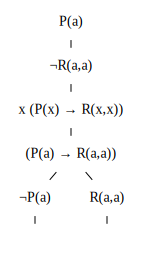

In [6]:
#@markdown ### Contrucción de tableaux

#@markdown Construye tableaux en lógica proposicional o de predicados para comprobar:
#@markdown - *Satisfacibilidad*. Introduce una o varias fórmulas en el
#@markdown `conjunto_de_formulas` y deja en blanco el campo `formula`.
#@markdown - *Validez*. Introduce una fórmula en `formula` y deja en blanco el campo
#@markdown `conjunto_de_formulas`.
#@markdown - *Consecuencia lógica*. Introduce las premisas en `conjunto_de_formulas`
#@markdown y la conclusión en `formula`.

#@markdown Es importante que las fórmulas del `conjunto_de_formulas` se separen por `';'`.

#@markdown Al pulsar ▶ se muestra el tableau junto a un texto que nos informa del
#@markdown resultado de la comprobación.

#@markdown <font color="red">⚠ ¡Cuidado! ¡Tableaux infinitos!</font>

conjunto_de_formulas = "P(a); todo x (P(x) -> R(x,x))" #@param {type:"string"}
formula = "R(a,a)" #@param {type:"string"}


if len(formula.strip()) > 0:
  conclusion = str(analizaFml(formula))
  premisas = []
  if len(conjunto_de_formulas.strip()) > 0:
    premisas = [str(analizaFml(form)) for form in conjunto_de_formulas.split(';')]
  with Capturing() as output:
    tab.tableau_test(conclusion, premisas, verbose=True)
  treeList = output[:-1]
  val = (output[-1].split(':')[1].strip()) == 'True'
  if (len(conjunto_de_formulas.strip()) > 0):
    if val:
      message = "La fórmula introducida es consecuencia lógica del conjunto de premisas."
    else:
      message = "La fórmula introducida no es consecuencia lógica del conjunto de premisas."
  else:
    if val:
      message = "La fórmula introducida es universalmente válida."
    else:
      message = "La fórmula introducida no es universalmente válida."
else:
  if len(conjunto_de_formulas.strip()) > 0:
    conjuntoFmls = [str(analizaFml(form)) for form in conjunto_de_formulas.split(';')]
    with Capturing() as output:
      theFml = "-(("+") & (".join(conjuntoFmls)+"))"
      tab.tableau_test(theFml, [], verbose=True)
    treeList = output[1:-1]
    val = (output[-1].split(':')[1].strip()) == 'True'
    if val:
      message = "El conjunto de fórmulas no es satisfacible."
    else:
      message = "El conjunto de fórmulas es satisfacible."
  else:
    raise Exception("Introduce al menos una fórmula.")

print(message+"\n")

graphviz.Source(toDot(treeList))


## Ejercicios de tableaux

**Ejercicio 1.**
Usando tableaux en lógica proposicional:
1. Determinar si la fórmula $(p\lor q)\land (p\lor\lnot q)\to p$ es
válida.
2. Encontrar una interpretación (si existe) que satisfaga el conjunto de
fórmulas siguiente: $$\{p\to\lnot p,\ t\to p,\ p\lor q\}$$
3. Determinar si la fórmula $p\to (q\to p)$ es contingente.
4. Determinar si se verifica la siguiente relación de consecuencia
lógica:
$$\{p\to q\lor r,\ \lnot r\}\models \lnot p$$
Si no se verifica, ofrecer una interpretación que sirva de
contraejemplo.
5. Determinar si se verifica la siguiente relación de consecuencia
lógica: $$\{p\lor q,\ p\to r, q\to s\}\models \lnot r\to s$$
Si no se verifica, ofrecer una interpretación que sirva de
contraejemplo.

**Ejercicio 2.**
Mediante tableaux prueba o refuta lo que se indica en cada
uno de los apartados siguientes. Al terminar el tableau, indica por
qué nos permite dar una prueba o una refutación, según corresponda:
1. El conjunto de fórmulas $\{ \forall x (Px \to Qx), \exists x
\neg Qx, \forall x \neg Px \}$ es satisfacible.
2. La fórmula $\exists x (Px \wedge (Sx \wedge \neg Rx))$ es
consecuencia lógica de las fórmulas $\forall x ((Px \wedge Qx) \to
\neg Rx)$ y $\exists x (Px \wedge (Qx \wedge Sx))$.
3. La fórmula $\exists x ((Qx \wedge Sx) \vee (Rx \wedge Sx))$ es
consecuencia lógica de las fórmulas $\forall x (Px \to (Qx \vee
Rx))$ y $\exists x (Px \wedge Sx)$.
4. La fórmula $\exists x ((Qx \vee Sx) \wedge (Rx \vee Sx))$ es
consecuencia lógica de las fórmulas $\forall x (Px \to (Qx \wedge
Rx))$ y $\exists x (Px \vee Sx)$.
5. La fórmula $\exists y\forall x (Rxy \to \lnot Px) \to \exists
y\forall x (Px\land Qxy\to \lnot Rxy)$ es universalmente válida.
6. $\{\forall x (\exists y Rxy\to \forall z Rzx),\ \exists
x\exists y Rxy\}\models \forall x Rxx$
7. $\models (\exists xPx \to \forall y Qy)\leftrightarrow \forall
x(Px\to \forall y Qy)$
8. $\{\forall x(Px\to Rx\land Qx),\ \forall x (Rx \to
(Qx\to\lnot Sx)),\ \exists x (Px\land \lnot Sx)\}$ es un conjunto
satisfacible.
9. El conjunto $\{\exists x\forall y Rxy,\ \lnot\forall y\exists
x Rxy\}$ es satisfacible.
10. $\forall x Rx\to \exists xPx\models\exists x(Rx\to Px)$

**Ejercicio 3.**
Utilizar tableaux para demostrar cada una de las
siguientes relaciones de equivalencia:     
1. $\forall x (Px\land Qx)\equiv \forall xPx\land \forall x Qx$
2. $\exists x (Px\lor Qx)\equiv \exists xPx\lor \exists x Qx$
3. $\forall x (\exists y Qy \land Px) \equiv \exists y Qy \land
\forall x Px$
4. $\forall x (\exists y Qy \lor Px) \equiv \exists y Qy \lor
\forall x Px$
5. $\exists x (\exists y Qy \land Px) \equiv \exists y Qy \land
\exists x Px$

**Ejercicio 4.**
Utilizar tableaux para encontrar estructuras que permitan
demostrar lo siguiente:
1. $\forall x (Px\lor Qx)\not\equiv \forall xPx\lor \forall x Qx$
2. $\exists x (Px\land Qx)\not\equiv \exists xPx\land \exists x
Qx$